In [1]:
from torch import nn
from torchsummary import summary

/home/alexis/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# cnn = ModeloCNN()

# #Poner la tupla de shape
# #Normalizar valores de la tupla para mejorar la velocidad de la CNN

# summary(cnn.cuda(), (1, 64, 44))

In [3]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder


In [4]:
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# data_dir = "../data/spectrograms"
data_dir = "../data/MelSpectrograms"

#load the train and test data
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),transforms.ToTensor()
]))

In [5]:
print("Follwing classes are there : \n",dataset.classes)

Follwing classes are there : 
 ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'vocal']


In [6]:
print("There are "+str(len(dataset.classes))+" classes")

There are 10 classes


In [7]:
print("Hay "+str(len(dataset))+" imagenes")

Hay 4096 imagenes


In [8]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Label : bass


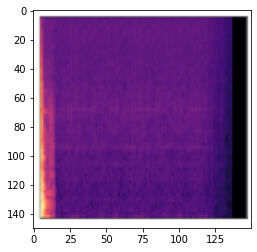

In [9]:
from matplotlib import pyplot as plt 
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*dataset[0])

In [10]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 32
val_size = 580
test_size = 300
train_size = len(dataset) - (val_size + test_size)

train_data,val_data,test_data = random_split(dataset,[train_size,val_size,test_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_data)}")


#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)

Length of Train Data : 3216
Length of Validation Data : 580
Length of Test Data : 300


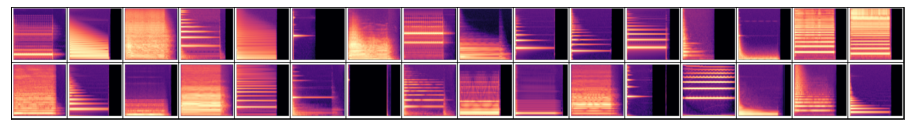

In [11]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break
        
show_batch(train_dl)

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch[0].to(device), batch[1].to(device) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
#         self.images=images
#         self.labels=labels
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
class ModeloCNN(ImageClassificationBase):
    #Creamos el modelo, con cuantas capas queramos
#     images=None
#     labels=None
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,10)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
#     print(outputs)
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
    
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [15]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 0.001

model = ModeloCNN().to(device)
#fitting the model on training data and record the result after each epoch

In [16]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

[{'val_loss': tensor(0.8673, device='cuda:0'), 'val_acc': tensor(0.6562)}, {'val_loss': tensor(1.0634, device='cuda:0'), 'val_acc': tensor(0.5312)}, {'val_loss': tensor(1.1021, device='cuda:0'), 'val_acc': tensor(0.5938)}, {'val_loss': tensor(0.8902, device='cuda:0'), 'val_acc': tensor(0.6719)}, {'val_loss': tensor(1.0092, device='cuda:0'), 'val_acc': tensor(0.5938)}, {'val_loss': tensor(1.2281, device='cuda:0'), 'val_acc': tensor(0.5156)}, {'val_loss': tensor(1.1102, device='cuda:0'), 'val_acc': tensor(0.5938)}, {'val_loss': tensor(0.9878, device='cuda:0'), 'val_acc': tensor(0.5938)}, {'val_loss': tensor(0.8375, device='cuda:0'), 'val_acc': tensor(0.6875)}, {'val_loss': tensor(1.8848, device='cuda:0'), 'val_acc': tensor(0.2500)}]
Epoch [0], train_loss: 1.6215, val_loss: 1.0981, val_acc: 0.5688
[{'val_loss': tensor(0.3957, device='cuda:0'), 'val_acc': tensor(0.8906)}, {'val_loss': tensor(0.4017, device='cuda:0'), 'val_acc': tensor(0.8281)}, {'val_loss': tensor(0.3211, device='cuda:0'),

In [17]:
# result = evaluate(model, test_dl)
# result

[{'val_loss': tensor(0.0153, device='cuda:0'), 'val_acc': tensor(1.)}, {'val_loss': tensor(0.0071, device='cuda:0'), 'val_acc': tensor(1.)}, {'val_loss': tensor(0.0022, device='cuda:0'), 'val_acc': tensor(1.)}, {'val_loss': tensor(0.0005, device='cuda:0'), 'val_acc': tensor(1.)}, {'val_loss': tensor(0.0681, device='cuda:0'), 'val_acc': tensor(0.9688)}, {'val_loss': tensor(0.0003, device='cuda:0'), 'val_acc': tensor(1.)}, {'val_loss': tensor(0.0091, device='cuda:0'), 'val_acc': tensor(1.)}, {'val_loss': tensor(0.0360, device='cuda:0'), 'val_acc': tensor(0.9688)}, {'val_loss': tensor(0.1064, device='cuda:0'), 'val_acc': tensor(0.9688)}, {'val_loss': tensor(0.3243, device='cuda:0'), 'val_acc': tensor(0.9167)}]


{'val_loss': 0.05692801997065544, 'val_acc': 0.9822916984558105}

In [18]:
# print(model.images,model.labels)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
        